## The Metropolis-Hastings Algorithm <a class="anchor" id="three"></a>

**The Metropolis-Hastings algorithm** adopts the following acceptance probability for newly proposed points to step to:

$$ p_{\rm acc}(\theta_i,\theta_{i+1}) = { p(\theta_{i+1}) \over p(\theta_i) }, $$

where the proposed point $\theta_{i+1}$ is drawn from an *arbitrary* symmetric density distribution $T(\theta_{i+1}\,|\,\theta_i)$. Since it is symmetric, the **ratio of transition probabilities cancels out and detailed balance is ensured**. A Gaussian distribution centered on the current point $\theta_i$ is often used for $T(\theta_{i+1}|\theta_i)$.

This algorithm guarantees that the chain will reach an equilibrium, or stationary, distribution, and it will approximate a sample drawn from $p(\theta)$! 

**In summary, the Metropolis-Hastings algorithm consists of these steps:**

1. Given $\theta_i$ and $T(\theta_{i+1}|\theta_i)$, draw a proposed value for $\theta_{i+1}.$ 
2. Compute acceptance probability $p_{\rm acc}(\theta_i,\theta_{i+1})$.
3. Draw a random number between 0 and 1 from a uniform distribution; if it is smaller than $p_{\rm acc}(\theta_i,\theta_{i+1})$, then accept $\theta_{i+1}$. 
4. ***If $\theta_{i+1}$ is accepted added it to the chain. If not, add $\theta_{i}$ to the chain.***
5. Use the chain (of $\theta$ values) for inference; e.g. a histogram of $\theta$ is an estimator of the posterior pdf for $\theta$, $p(\theta)$, and the expectation value for $\theta$ can be computed from 

  $$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{N} \sum_{i=1}^N g(\theta_i).$$

where N is the number of elements in the chain (e.g. the expectation value for $\theta$ is simply the mean value of chain elements). 

***Step 4*** is very important. If we only accepted points of higher probability then we would only move up the posterior density to find its maximum. But we want to map out the full posterior density, so sometimes we must settle for less!

In [1]:
# Animation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
from IPython.display import display, HTML

from scipy.stats import norm
from scipy.stats import multivariate_normal

# Target distribution: mixture of two Gaussians
def target_pdf(x):
    gauss1 = multivariate_normal(mean=[1, 0], cov=[[0.3, 0], [0, 0.3]])
    gauss2 = multivariate_normal(mean=[-1, 1], cov=[[0.5, 0], [0, 0.5]])
    return gauss1.pdf(x) + gauss2.pdf(x)

# Initialize sampling
samples = [[0.0, 0.0]]
proposal_std = 1

fig, ax = plt.subplots(figsize=(8, 8))

# Plot target PDF background
x = np.linspace(-3, 3, 200)
y = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = np.array([target_pdf(p) for p in pos.reshape(-1, 2)]).reshape(200, 200)
ax.imshow(Z, extent=[-3, 3, -3, 3], origin='lower', cmap='viridis', alpha=0.5)
ax.set_title("Metropolis-Hastings Sampling")
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# Plot elements
scat = ax.scatter([], [], color='red', s=10)
path_line, = ax.plot([], [], color='white', lw=0.5)
arrow = FancyArrowPatch((0, 0), (0, 0), arrowstyle="->", color='gray', mutation_scale=15)
ax.add_patch(arrow)

# Text annotations
text_current = ax.text(0, 0, '', color='white', fontsize=8)
text_proposal = ax.text(0, 0, '', color='white', fontsize=8)
text_alpha = ax.text(0, 0, '', color='white', fontsize=8)

def init():
    scat.set_offsets(np.empty((0, 2)))
    path_line.set_data([], [])
    arrow.set_positions((0, 0), (0, 0))
    arrow.set_visible(False)
    text_current.set_text('')
    text_proposal.set_text('')
    text_alpha.set_text('')
    return scat, path_line, arrow, text_current, text_proposal, text_alpha

def update(frame):
    current = samples[-1]
    proposal = current + np.random.normal(scale=proposal_std, size=2)

    p_current = target_pdf(np.array(current))
    p_proposal = target_pdf(np.array(proposal))
    alpha = min(1, p_proposal / p_current)

    # Accept/reject logic
    if np.random.rand() < alpha:
        samples.append(proposal)
        arrow.set_color('green')
    else:
        samples.append(current)
        arrow.set_color('red')

    # Update scatter and path
    path = np.array(samples)
    scat.set_offsets(path)
    path_line.set_data(path[:, 0], path[:, 1])

    # Update arrow and make visible
    arrow.set_positions((current[0], current[1]), (proposal[0], proposal[1]))
    arrow.set_visible(True)

    # Annotate with probabilities
    mid_x = (current[0] + proposal[0]) / 2
    mid_y = (current[1] + proposal[1]) / 2

    text_current.set_position((mid_x + 0.1, mid_y + 0.1))
    text_current.set_text(f"p(current)={p_current:.3f}")

    text_proposal.set_position((mid_x + 0.1, mid_y))
    text_proposal.set_text(f"p(proposal)={p_proposal:.3f}")

    text_alpha.set_position((mid_x + 0.1, mid_y - 0.1))
    text_alpha.set_text(f"p(acc)={alpha:.3f}")

    return scat, path_line, arrow, text_current, text_proposal, text_alpha

ani = FuncAnimation(
    fig, update, init_func=init,
    frames=100, interval=200, blit=False
)

display(HTML(ani.to_jshtml()))
plt.close()
    

# Nested sampling algorithm

From *dynesty* crash course, https://dynesty.readthedocs.io/en/stable/dynamic.html

Nested sampling is a method for estimating the Bayesian evidence $\mathcal{Z}$ first proposed and developed by John Skilling. The basic idea is to approximate the evidence by integrating the prior in nested “shells” of constant likelihood. Unlike Markov Chain Monte Carlo (MCMC) methods which can only generate samples proportional to the posterior, Nested Sampling simultaneously estimates both the evidence and the posterior. It also has a variety of appealing statistical properties, which include:

1. well-defined stopping criteria for terminating sampling,

2. generating a sequence of independent samples,

3. flexibility to sample from complex, multi-modal distributions,

4. the ability to derive how statistical and sampling uncertainties impact results from a single run, and

5. being trivially parallelizable.

Recap the *bayesian evidence*:

$$P(\boldsymbol{D}|M) = \mathcal{Z} = \int_{\Omega_\Theta}\mathcal{L}(\boldsymbol{\Theta})\pi(\boldsymbol{\Theta})d\boldsymbol{\Theta}$$

The integral is taken over the entire domain $\Omega_\Theta$ of $\boldsymbol{\Theta}$ (prior volume). For complicated data and models, the posterior is often intractable and must be estimated using numerical methods.

Nested sampling is a method for estimating the Bayesian evidence 
 first proposed and developed by John Skilling. The basic idea is to approximate the evidence by integrating the prior in nested “shells” of constant likelihood. Unlike Markov Chain Monte Carlo (MCMC) methods which can only generate samples proportional to the posterior, Nested Sampling simultaneously estimates both the evidence and the posterior. It also has a variety of appealing statistical properties, which include:

- well-defined stopping criteria for terminating sampling,
- generating a sequence of independent samples,
- flexibility to sample from complex, multi-modal distributions,
- the ability to derive how statistical and sampling uncertainties impact results from a single run, and
- being trivially parallelizable.

Nested Sampling attempts to estimate $\mathcal{L}$ by treating the integral of the posterior over all $\boldsymbol{\Theta}$ as instead an integral over the prior volume. 

$$X(\lambda) = \int_{\Theta:\mathcal{L}>\lambda}\pi(\boldsymbol{\Theta})d\boldsymbol{\Theta}$$

$X(\lambda)$ is the total prior mass where the likelihood is greater than $\lambda$ (iso-likelihood contour).

We can write:

$$\mathcal{Z}=\int \mathcal{L}(\theta)\pi(\theta)d\theta = \int \left( \int_0^{\mathcal{L}(\theta)} d\lambda  \right)\pi(\theta)d\theta= \int_0^{+\infty} \left( \int_{\mathcal{L}(\theta)>\lambda} \pi(\theta)d\theta  \right) d\lambda$$

thanks to Fubini theorem. Since $X(\lambda)$ is decreasing and invertible, let $\lambda=\mathcal{L}(X)$. Then:

$$\int_0^{+\infty} X(\lambda)d\lambda = \int_1^0 X \frac{d\mathcal{L}(X)}{dX}dX = [\mathcal{L}(X)\, X ]_1^0 - \int_1^0 \mathcal{L}(X)\,dX = \int_0^1 \mathcal{L}(X)dX$$

The limits flip because $X(\lambda)$ goes from 1 to 0 as $\lambda$ increases from 0 to $+\infty$. 

$$\mathcal{Z}=\int_0^1 \mathcal{L}(X)\,dX$$

This is the nested sampling identity, expressing the Bayesian evidence as an integral over prior volume.



**Algorithm**

Draw $K$ live points from the prior $\pi(\Theta)$. At each iteration $i$ remove the live point with the lowest likelihood $\mathcal{L}_i$ and replace it with a new live point sampled from the prior subject to the constrain $\mathcal{L}_{i+1} \geq \mathcal{L}$. This sampling procedure actually allows us to estimate the prior volume of the previous live point (a “dead” point) as:
$$
\ln{X_i}\approx\frac{i\pm\sqrt{i}}{K}
$$

Once some stopping criteria are reached and sampling terminates, the remaining set of live points are distributed uniformly within the final prior volume. These can then be “recycled” and added to the list of samples.

The evidence integral is numerically estimated with:

$$
\mathcal{Z} = \int_0^1\mathcal{L}(X)dX\approx\sum_{i=1}^Nf(\mathcal{L_i})f(\Delta X_i) = \sum_{i=1}^Nw_i
$$

where $w_i$ is each point estimated weight. For linear integration scheme using rectangles $f(\mathcal{L}_i)=\mathcal{L}_i$ and $f(\delta X_i)=X_{i-1}-X_i$

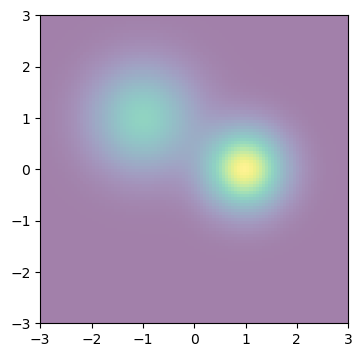

In [13]:
# --- Target distribution: mixture of two Gaussians ---
def target_pdf(x):
    gauss1 = multivariate_normal(mean=[1, 0], cov=[[0.3, 0], [0, 0.3]])
    gauss2 = multivariate_normal(mean=[-1, 1], cov=[[0.5, 0], [0, 0.5]])
    return gauss1.pdf(x) + gauss2.pdf(x)

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_aspect('equal')

# Plot target PDF background
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = np.array([target_pdf(p) for p in pos.reshape(-1, 2)]).reshape(100, 100)
ax.imshow(Z, extent=[-3, 3, -3, 3], origin='lower', cmap='viridis', alpha=0.5)
plt.show()

In [18]:
print(live_points)
print(live_points[np.argmin(live_likelihoods)])

[[-2.13968942  1.13854697]
 [-3.40660549 -2.98907717]
 [ 1.50797444 -0.93859452]
 ...
 [ 1.06238346 -0.54802823]
 [ 1.77960895  1.74168668]
 [-2.12192729 -0.60753242]]
[ 3.92391551 -3.8221169 ]


In [ ]:

# --- Uniform prior on a bounding box ---
def sample_prior(n_samples):
    # Assuming prior is uniform in [-4, 4] x [-4, 4]
    return np.random.uniform(low=[-4, -4], high=[4, 4], size=(n_samples, 2))

# --- Initial setup ---
K = 500
live_points = sample_prior(K)
live_likelihoods = np.array([target_pdf(x) for x in live_points])

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

# Initial scatter plot
sc = ax.scatter(live_points[:, 0], live_points[:, 1],
                c=live_likelihoods, cmap='viridis',
                s=30, edgecolor='k')

# Red point to show worst likelihood
red_point = ax.scatter([], [], c='red', s=60, edgecolor='k', label='Worst point')
plt.colorbar(sc, ax=ax, label='Likelihood')

# --- Animation update function ---
def update(frame):
    global live_points, live_likelihoods

    # Find and show the worst point (lowest likelihood)
    min_index = np.argmin(live_likelihoods)
    worst_point = live_points[min_index]
    red_point.set_offsets([worst_point])

    # Remove it from live points
    worst_likelihood = live_likelihoods[min_index]
    live_points = np.delete(live_points, min_index, axis=0)
    live_likelihoods = np.delete(live_likelihoods, min_index)
    
    
    # Resample a new point with higher likelihood
    while True:
        new_point = sample_prior(1)[0]
        new_likelihood = target_pdf(new_point)
        if new_likelihood > worst_likelihood:
            break

    # Add new point
    live_points = np.vstack([live_points, new_point])
    live_likelihoods = np.append(live_likelihoods, new_likelihood)

    # Update scatter plot
    sc.set_offsets(live_points)
    sc.set_array(live_likelihoods)

    return sc,

# --- Create animation ---
ani = FuncAnimation(
    fig, update,
    frames=1000, interval=200, blit=False
)

display(HTML(ani.to_jshtml()))
plt.close()


Animation size has reached 20997492 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
